In [211]:
# Importing the most important modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import seaborn as sns
import warnings
import pickle
import time
from tqdm.notebook import tqdm

# Import plotly modules to view time series in a more interactive way
import plotly.graph_objects as go
import plotly.offline as pyo
from matplotlib.pyplot import cm
from IPython.display import Image

# Importing time series split for cross validation of time series models
from sklearn.model_selection import TimeSeriesSplit

# For Data Mining
import os, glob
from pandas import read_csv

# For Data Cleaning
from datetime import datetime
import missingno as msno

from matplotlib import pyplot
import matplotlib.dates as mdates

# Importing metrics to evaluate the implemented models
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Importing fbprophet for Prophet Model
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [212]:
# Setting the random seed for reproducability and several plotting style parameters
%matplotlib inline
plt.style.use('seaborn')
pyo.init_notebook_mode()
sns.set(rc={'figure.figsize':(14,8)})
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
RSEED = 42

## Time series

Analyzing Time series: 
The vaccination progress is reported daily, so that we have timeseries to analyze. 

In [213]:
#import cleaned data set:
df_daily = pd.read_csv('df2.csv', index_col=None)
#change date to datetime
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily.head(3)

country iso_code       date  total_vaccinations  people_vaccinated  \
0  Afghanistan      AFG 2021-02-23                 NaN                NaN   
1  Afghanistan      AFG 2021-02-24                 NaN                NaN   
2  Afghanistan      AFG 2021-02-25                 NaN                NaN   

   people_fully_vaccinated  daily_vaccinations  \
0                      0.0              1367.0   
1                      0.0              1367.0   
2                      0.0              1367.0   

   total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
0                             NaN                            NaN   
1                             NaN                            NaN   
2                             NaN                            NaN   

   people_fully_vaccinated_per_hundred  daily_vaccinations_per_million  \
0                                  0.0                            35.0   
1                                  0.0                            35.0   
2                                  0.0                            35.0   

             vaccines  
0  Oxford/AstraZeneca  
1  Oxford/AstraZeneca  
2  Oxford/AstraZeneca

In [214]:
#split date into day, month, year and weekday_name:
df_daily.date.dt.to_period('D').dt.to_timestamp()
df_daily.date.dt.to_period('M').dt.to_timestamp()
df_daily.date.dt.to_period('Y').dt.to_timestamp()


df_daily['day'] = df_daily['date'].dt.day
df_daily['month'] = df_daily['date'].dt.month
df_daily['year'] = df_daily['date'].dt.year
df_daily['weekday_name'] = df_daily['date'].dt.day_name()#day_of_week  
# Display a random sampling of 5 rows
df_daily.sample(5, random_state=0)

country iso_code       date  total_vaccinations  people_vaccinated  \
4512   Mauritius      MUS 2021-02-02                 NaN                NaN   
2412     Finland      FIN 2021-02-09            227427.0           173558.0   
4732    Mongolia      MNG 2021-03-11             48265.0                NaN   
4245  Luxembourg      LUX 2021-01-08                 NaN                NaN   
5700       Qatar      QAT 2021-03-11                 NaN                NaN   

      people_fully_vaccinated  daily_vaccinations  \
4512                      0.0                58.0   
2412                  53869.0              9065.0   
4732                      0.0              5009.0   
4245                      0.0                62.0   
5700                      0.0             15381.0   

      total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
4512                             NaN                            NaN   
2412                            4.10                           3.13   
4732                            1.47                            NaN   
4245                             NaN                            NaN   
5700                             NaN                            NaN   

      people_fully_vaccinated_per_hundred  daily_vaccinations_per_million  \
4512                                 0.00                            46.0   
2412                                 0.97                          1636.0   
4732                                 0.00                          1528.0   
4245                                 0.00                            99.0   
5700                                 0.00                          5339.0   

                                          vaccines  day  month  year  \
4512                            Oxford/AstraZeneca    2      2  2021   
2412  Moderna, Oxford/AstraZeneca, Pfizer/BioNTech    9      2  2021   
4732                            Oxford/AstraZeneca   11      3  2021   
4245  Moderna, Oxford/AstraZeneca, Pfizer/BioNTech    8      1  2021   
5700                               Pfizer/BioNTech   11      3  2021   

     weekday_name  
4512      Tuesday  
2412      Tuesday  
4732     Thursday  
4245       Friday  
5700     Thursday

In [215]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

In [216]:
#select required columns:
df_time = df_daily.copy()
df_time.set_index('date')
df_time = df_time[['date','country', 'daily_vaccinations', 'people_fully_vaccinated_per_hundred']]
df_time.sample(5)

date             country  daily_vaccinations  \
6612 2021-01-09               Spain             47569.0   
2182 2021-01-27               Egypt               219.0   
6983 2021-02-03              Turkey            117243.0   
4532 2020-12-29              Mexico              3121.0   
2113 2021-03-16  Dominican Republic             30055.0   

      people_fully_vaccinated_per_hundred  
6612                                  0.0  
2182                                  0.0  
6983                                  0.0  
4532                                  0.0  
2113                                  0.0

In [217]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

ID
date                                  0
country                               0
daily_vaccinations                    6
people_fully_vaccinated_per_hundred   0

We have 6 missing values for daily_vaccinations, which has to be further investigated  as all values were filled during cleaning activities but for now we just drop the 6 missing values.

In [218]:
df_time.dropna(axis=0)

date      country  daily_vaccinations  \
0    2021-02-23  Afghanistan              1367.0   
1    2021-02-24  Afghanistan              1367.0   
2    2021-02-25  Afghanistan              1367.0   
3    2021-02-26  Afghanistan              1367.0   
4    2021-02-27  Afghanistan              1367.0   
...         ...          ...                 ...   
7492 2021-03-20     Zimbabwe               836.0   
7493 2021-03-21     Zimbabwe               910.0   
7494 2021-03-22     Zimbabwe               805.0   
7495 2021-03-23     Zimbabwe               655.0   
7496 2021-03-24     Zimbabwe              1400.0   

      people_fully_vaccinated_per_hundred  
0                                     0.0  
1                                     0.0  
2                                     0.0  
3                                     0.0  
4                                     0.0  
...                                   ...  
7492                                  0.0  
7493                                  0.0  
7494                                  0.0  
7495                                  0.0  
7496                                  0.0  

[7491 rows x 4 columns]

In [219]:
df_time.isnull().any()

date                                   False
country                                False
daily_vaccinations                      True
people_fully_vaccinated_per_hundred    False
dtype: bool

In [220]:
df_time.dropna(inplace = True)

In [221]:
#check for missing values in %
round(100*(df_time.isnull().sum()/len(df_time.index)),0)

date                                   0.0
country                                0.0
daily_vaccinations                     0.0
people_fully_vaccinated_per_hundred    0.0
dtype: float64

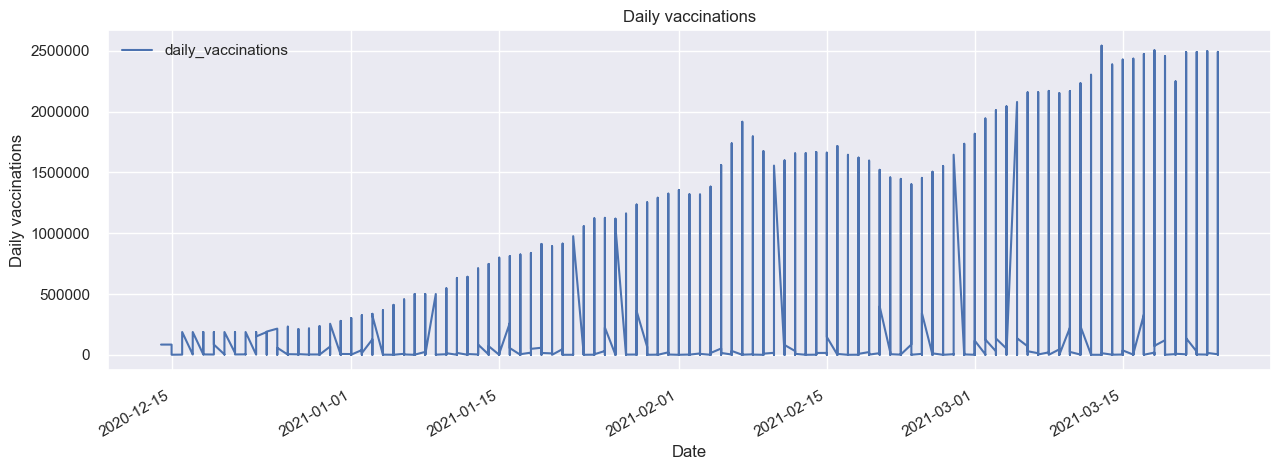

In [222]:
# plot the time series for daily vaccinations:
df_time1= df_time[['date','daily_vaccinations']]
df_time1.set_index('date', inplace=True)
ax1 = df_time1.plot()
# Add title and axis names

ax1.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Daily vaccinations')
plt.xlabel('Date')
plt.ylabel('Daily vaccinations')

pyplot.show()

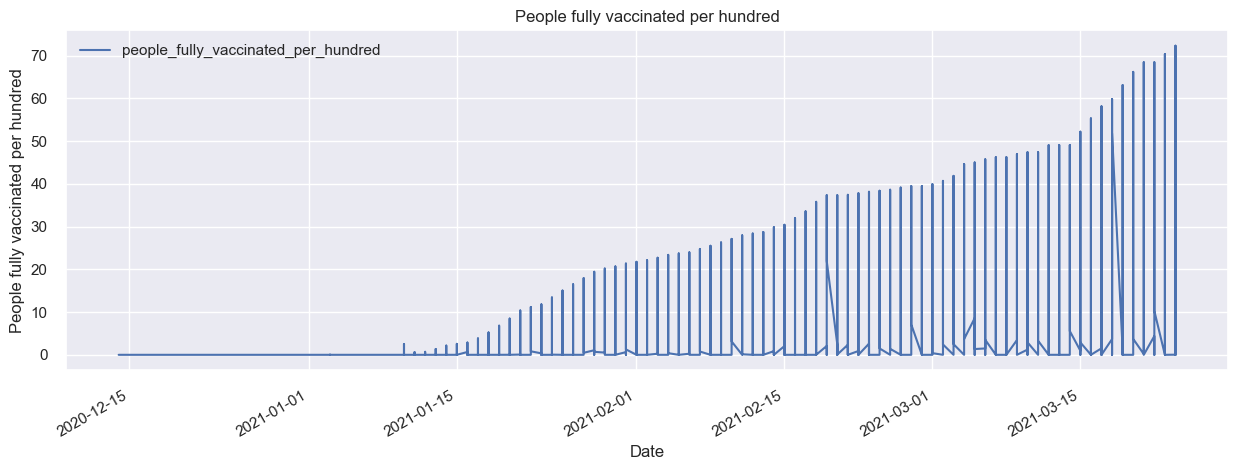

In [224]:
# plot the time series for daily vaccinations:
df_time_p= df_time[['date','people_fully_vaccinated_per_hundred']]
df_time_p.set_index('date', inplace=True)
ax1 = df_time_p.plot()
# Add title and axis names

ax1.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('People fully vaccinated per hundred')
plt.xlabel('Date')
plt.ylabel('People fully vaccinated per hundred')

pyplot.show()

In [225]:
# sum up all vaccinations values per day for getting a global value
df_time_index = df_time[['date', 'daily_vaccinations', 'people_fully_vaccinated_per_hundred']]
df_time_index['date'] = pd.to_datetime(df_time_index.date)

df_time_index.set_index('date', inplace=True)
df_time_index.index.get_level_values('date').floor('D')
df_time_index = df_time_index.groupby('date').sum().reset_index()
df_time_index.to_csv('dates_aggregated.csv', encoding='utf-8', index=True)

In [228]:
#df_time.to_csv('timeseriesformodel.csv', encoding='utf-8', index=False)

for United States

In [232]:
#check for United States only:
df_time_us = df_time[df_time.country == 'United States']
df_time_us

date        country  daily_vaccinations  \
7313 2020-12-21  United States             57909.0   
7314 2020-12-22  United States            127432.0   
7315 2020-12-23  United States            150606.0   
7316 2020-12-24  United States            191001.0   
7317 2020-12-25  United States            215238.0   
...         ...            ...                 ...   
7402 2021-03-20  United States           2248285.0   
7403 2021-03-21  United States           2488734.0   
7404 2021-03-22  United States           2489697.0   
7405 2021-03-23  United States           2497025.0   
7406 2021-03-24  United States           2490889.0   

      people_fully_vaccinated_per_hundred  
7313                                 0.00  
7314                                 0.00  
7315                                 0.00  
7316                                 0.00  
7317                                 0.00  
...                                   ...  
7402                                12.87  
7403                                13.20  
7404                                13.43  
7405                                13.61  
7406                                13.86  

[94 rows x 4 columns]

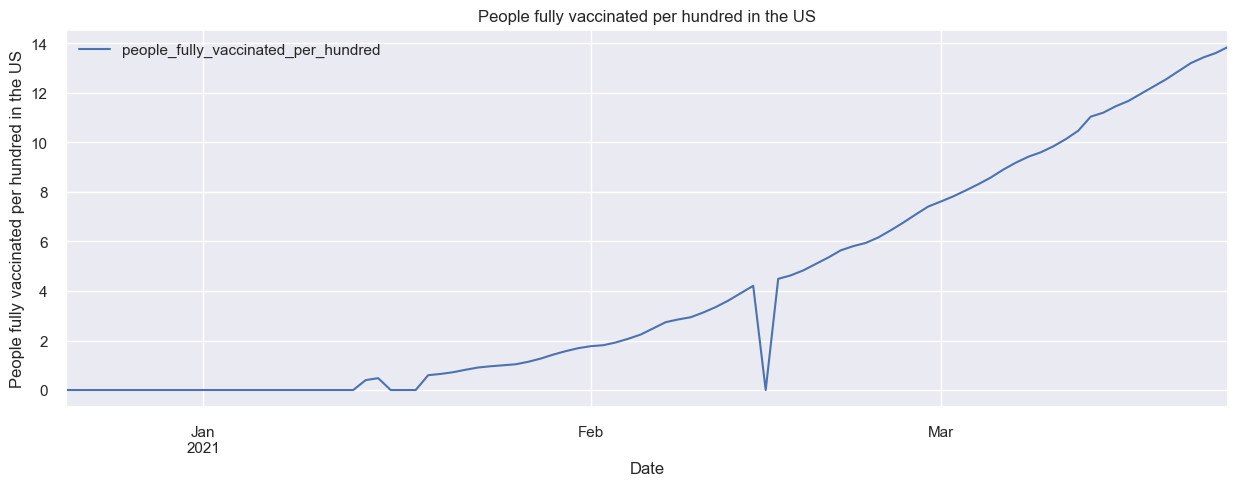

In [236]:
# plot the time series for daily vaccinations:
df_time_us= df_time_us[['date','people_fully_vaccinated_per_hundred']]
df_time_us.set_index('date', inplace=True)
ax1 = df_time_us.plot()
# Add title and axis names

ax1.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('People fully vaccinated per hundred in the US')
plt.xlabel('Date')
plt.ylabel('People fully vaccinated per hundred in the US')

pyplot.show()

## Prediction of global vaccination progress:

In [320]:
# sum up all vaccinations values per day for getting a global value
df_time_g = df_time[['date', 'daily_vaccinations', 'people_fully_vaccinated_per_hundred']]
df_time_g['date'] = pd.to_datetime(df_time_index.date)

df_time_g.set_index('date', inplace=True)


In [321]:
#df_time.to_csv('timeseriesformodel.csv', encoding='utf-8', index=False)

In [322]:
# aggregated daily vaccinations per day to show global values:
#df_time_g = df_time_index
df_time_g.head()
#df_time_m_agg = df_time_index
#df_time_m_agg.head()

daily_vaccinations  people_fully_vaccinated_per_hundred
date                                                               
2020-12-14              1367.0                                  0.0
2020-12-15              1367.0                                  0.0
2020-12-16              1367.0                                  0.0
2020-12-17              1367.0                                  0.0
2020-12-18              1367.0                                  0.0

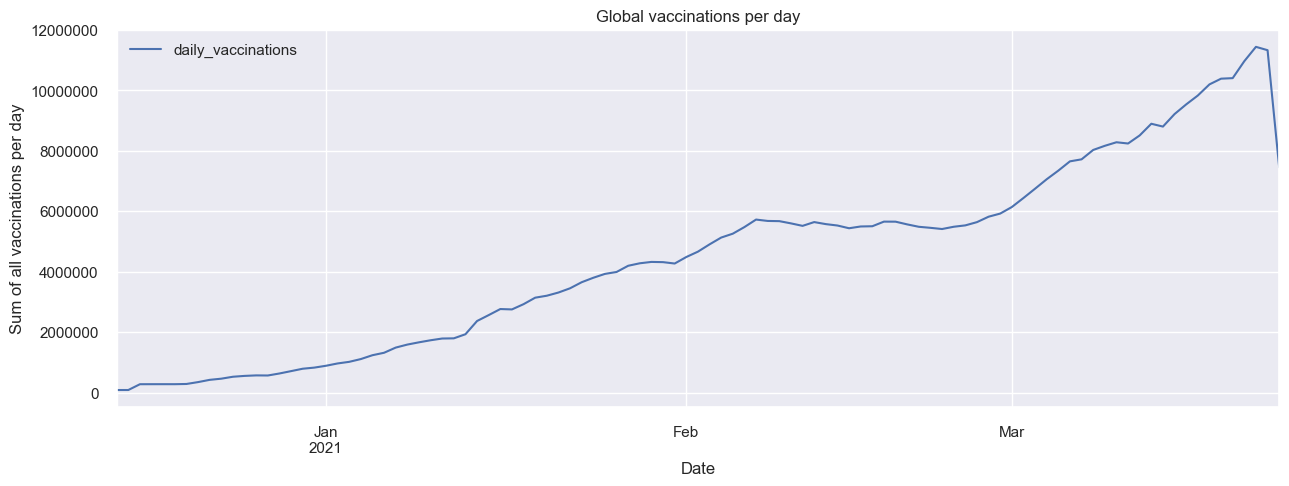

In [124]:
# plot the time series for global vaccinations per day(summed up for all countries per day):
df_time_m_agg1 = df_time_m_agg[['date','daily_vaccinations']]
df_time_m_agg1.set_index('date', inplace=True)
ax1 = df_time_m_agg1.plot()
# Add title and axis names

ax1.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Global vaccinations per day')
plt.xlabel('Date')
plt.ylabel('Sum of all vaccinations per day')

pyplot.show()

In order to run our FB model we have to rename ‘date’ column as ‘ds’ and ‘passenger’ column as ‘y’.This renaming is mandatory.
First we split our data into a train and test data set to start running our model:

In [326]:
#train - test - split
df_time_g1 = df_time_g
df_time_g1.reset_index(inplace=True)
df_time_g1['cap']= 7790000000
df_time_g1.columns=['ds','y', 'cap']
#df_time_m_agg2 = df_time_m_agg1
#df_time_m_agg2.reset_index(inplace=True)
#world population
#df_time_m_agg2['cap']= 7790000000
#renaming columns in ds, y, cap:
#df_time_m_agg1.columns=['ds','y', 'cap']
train_test_split_ratio = int(len(df_time_m_agg2)*0.8)
train_data, test_data = df_time_m_agg2[:train_test_split_ratio], df_time_m_agg2[train_test_split_ratio:]

train_data

ds          y         cap
0  2020-12-14    84117.0  7790000000
1  2020-12-15    84835.0  7790000000
2  2020-12-16   276483.0  7790000000
3  2020-12-17   277373.0  7790000000
4  2020-12-18   277766.0  7790000000
..        ...        ...         ...
75 2021-02-27  5818893.0  7790000000
76 2021-02-28  5922539.0  7790000000
77 2021-03-01  6138734.0  7790000000
78 2021-03-02  6437678.0  7790000000
79 2021-03-03  6745631.0  7790000000

[80 rows x 3 columns]

In [ ]:
#train - test - split

df_time_m_agg2 = df_time_m_agg1
df_time_m_agg2.reset_index(inplace=True)
#world population
df_time_m_agg2['cap']= 7790000000
#renaming columns in ds, y, cap:
df_time_m_agg1.columns=['ds','y', 'cap']
train_test_split_ratio = int(len(df_time_m_agg2)*0.8)
train_data, test_data = df_time_m_agg2[:train_test_split_ratio], df_time_m_agg2[train_test_split_ratio:]

train_data

In [327]:
# prepare expected column names
#train_data.columns = ['ds', 'y', 'cap']
#train_data['ds']= pd.to_datetime(train_data['ds'])
# define the model
model = Prophet(growth = 'logistic', weekly_seasonality = True)
# fit the model
model.fit(train_data)
print(train_data.tail())

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          y         cap
75 2021-02-27  5818893.0  7790000000
76 2021-02-28  5922539.0  7790000000
77 2021-03-01  6138734.0  7790000000
78 2021-03-02  6437678.0  7790000000
79 2021-03-03  6745631.0  7790000000


In [328]:
#making daily predictions for one year:
future = model.make_future_dataframe(periods=7*20, freq='D')
future['cap']= 7790000000
future.tail()

ds         cap
215 2021-07-17  7790000000
216 2021-07-18  7790000000
217 2021-07-19  7790000000
218 2021-07-20  7790000000
219 2021-07-21  7790000000

In [329]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
215 2021-07-17  1.912544e+08  1.901737e+08  1.923337e+08
216 2021-07-18  1.957394e+08  1.946166e+08  1.968373e+08
217 2021-07-19  2.002760e+08  1.991484e+08  2.013180e+08
218 2021-07-20  2.050206e+08  2.040033e+08  2.061250e+08
219 2021-07-21  2.098972e+08  2.088105e+08  2.109379e+08


yhat: the forecasted value of our metric

yhat_lower: the lower bound of our forecasts

yhat_upper: the upper bound of our forecasts

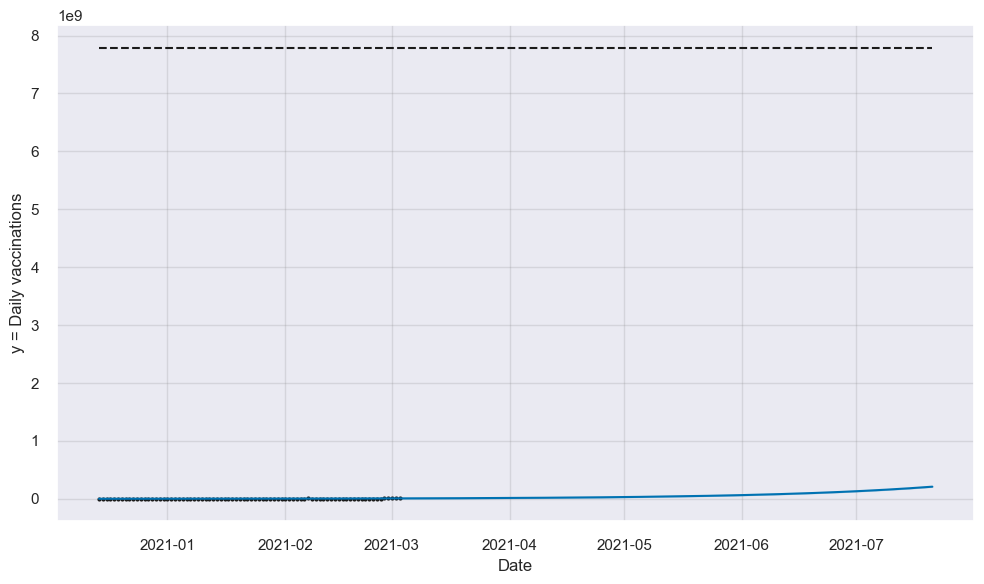

In [330]:
fig1 = model.plot(forecast, uncertainty=True,  xlabel='Date',
    ylabel='y = Daily vaccinations')
#ax.ticklabel_format(useOffset=False)
#ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
#fig1.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('1960-01-01','1961-01-01'))

Prophet plots the observed values of time series(black dots),the forecasted values(blue lines) and the uncertainty intervals of our forecasts(blue shaded region)

<AxesSubplot:xlabel='ds'>

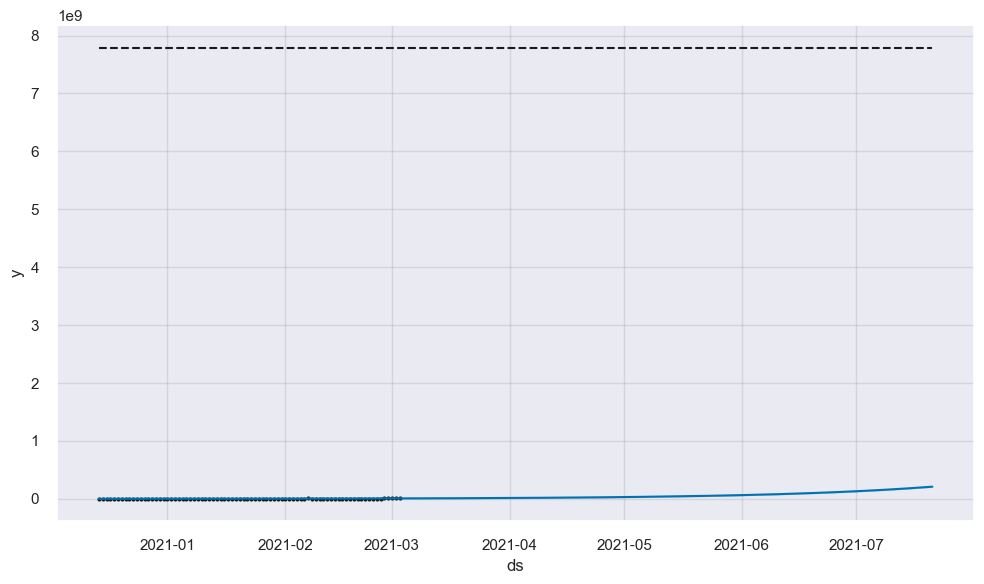

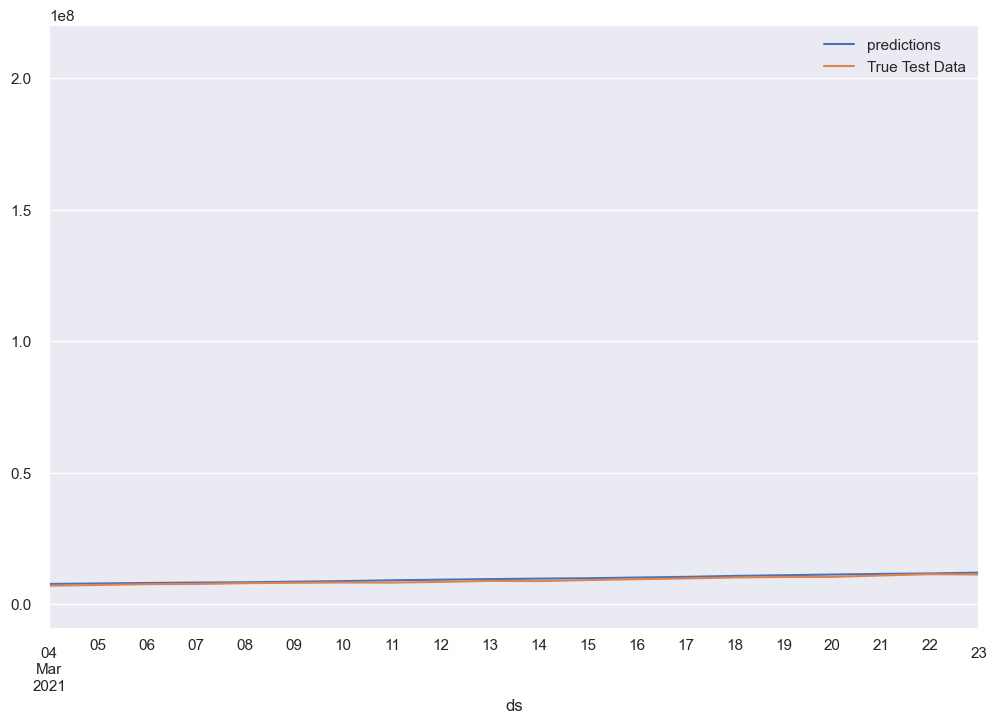

In [331]:
model.plot(forecast)
ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test_data.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2021-03-04','2021-03-23'))

In [80]:
#model.plot(forecast)
#ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
#test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('1960-01-01','1961-01-01'))

One other feature of Prophet is its ability to return components of our forecasts.This can help reveal how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values:

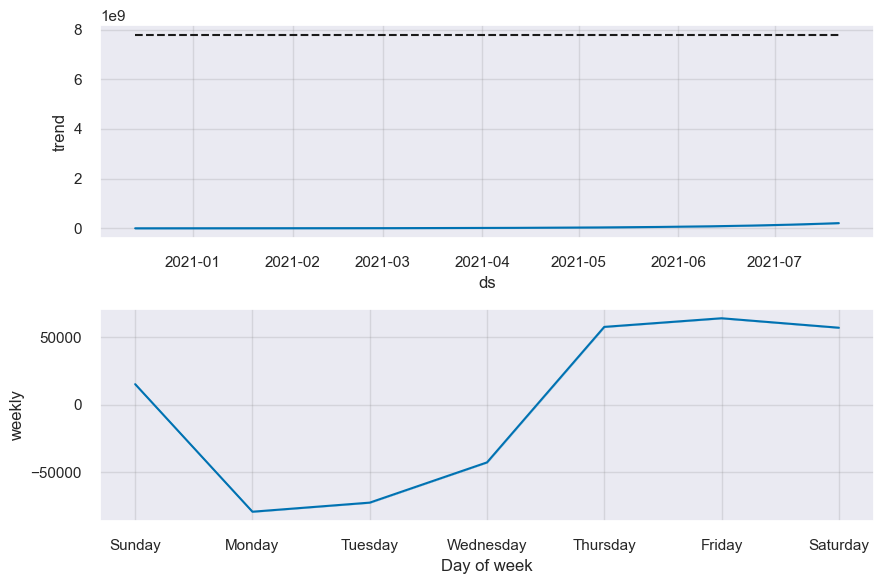

In [332]:
fig2 = model.plot_components(forecast)

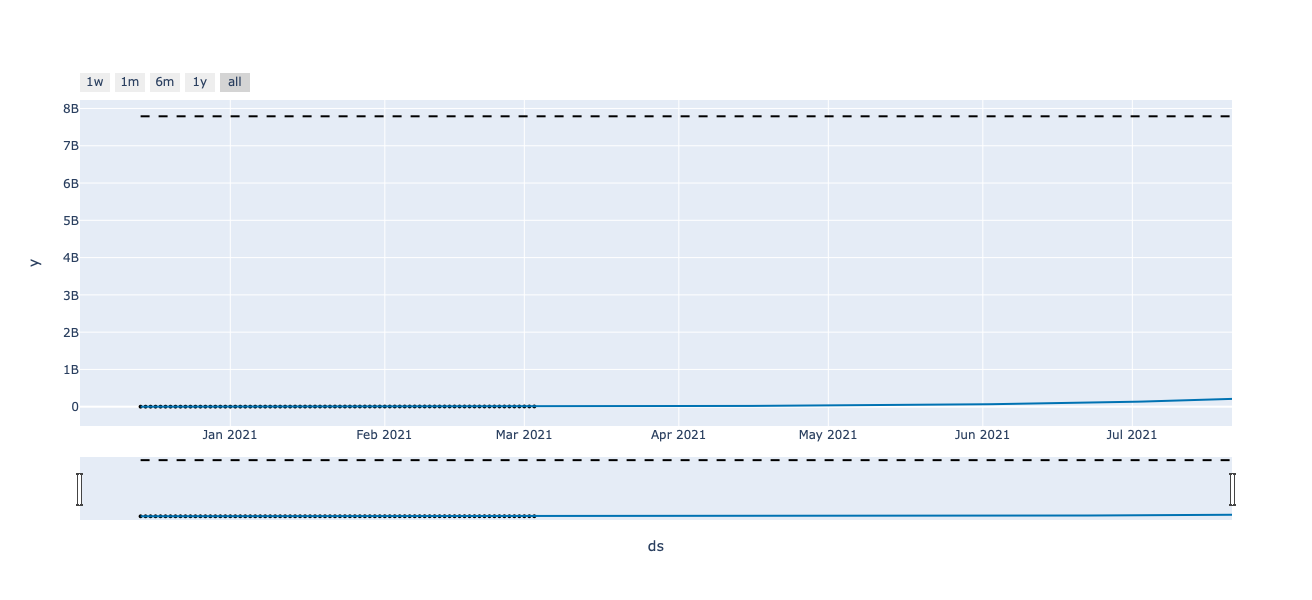

In [333]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

## Performance Metrics:

In [338]:

# Initial training period.
initial= 7*8
initial=str(initial)+' days'
#Period length that we perform the cross validation for.
period= 7
period=str(period)+' days'
#Horizon of prediction essentially for each fold.
horizon = 20
horizon=str(horizon)+' days'
fb_cv=cross_validation(model,initial=initial,period=period,
horizon=horizon)
# Performance Metrics of fb_cv
performance_metrics(fb_cv)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2021-02-11 00:00:00 and 2021-02-11 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

horizon           mse          rmse           mae      mape     mdape  \
0   2 days  2.463826e+12  1.569658e+06  1.559545e+06  0.278314  0.278314   
1   3 days  3.590584e+12  1.894884e+06  1.888826e+06  0.340400  0.340400   
2   4 days  4.894622e+12  2.212379e+06  2.206148e+06  0.402684  0.402684   
3   5 days  6.246259e+12  2.499252e+06  2.496169e+06  0.456525  0.456525   
4   6 days  7.796880e+12  2.792289e+06  2.787289e+06  0.506789  0.506789   
5   7 days  9.361531e+12  3.059662e+06  3.057908e+06  0.547867  0.547867   
6   8 days  1.170534e+13  3.421307e+06  3.412116e+06  0.603331  0.603331   
7   9 days  1.526285e+13  3.906770e+06  3.899584e+06  0.695526  0.695526   
8  10 days  1.900544e+13  4.359523e+06  4.354086e+06  0.788370  0.788370   
9  11 days  2.270550e+13  4.765029e+06  4.761259e+06  0.870809  0.870809   
10 12 days  2.686276e+13  5.182930e+06  5.177949e+06  0.953494  0.953494   
11 13 days  3.133720e+13  5.597964e+06  5.594751e+06  1.026553  1.026553   
12 14 days  3.604717e+13  6.003930e+06  6.000055e+06  1.088951  1.088951   
13 15 days  4.196219e+13  6.477823e+06  6.472723e+06  1.158465  1.158465   
14 16 days  4.757268e+13  6.897295e+06  6.895307e+06  1.203392  1.203392   
15 17 days  5.264461e+13  7.255661e+06  7.253114e+06  1.235281  1.235281   
16 18 days  5.744986e+13  7.579569e+06  7.578400e+06  1.256658  1.256658   
17 19 days  6.149829e+13  7.842084e+06  7.841014e+06  1.247155  1.247155   
18 20 days  6.592678e+13  8.119531e+06  8.118189e+06  1.231735  1.231735   

    coverage  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
5        0.0  
6        0.0  
7        0.0  
8        0.0  
9        0.0  
10       0.0  
11       0.0  
12       0.0  
13       0.0  
14       0.0  
15       0.0  
16       0.0  
17       0.0  
18       0.0

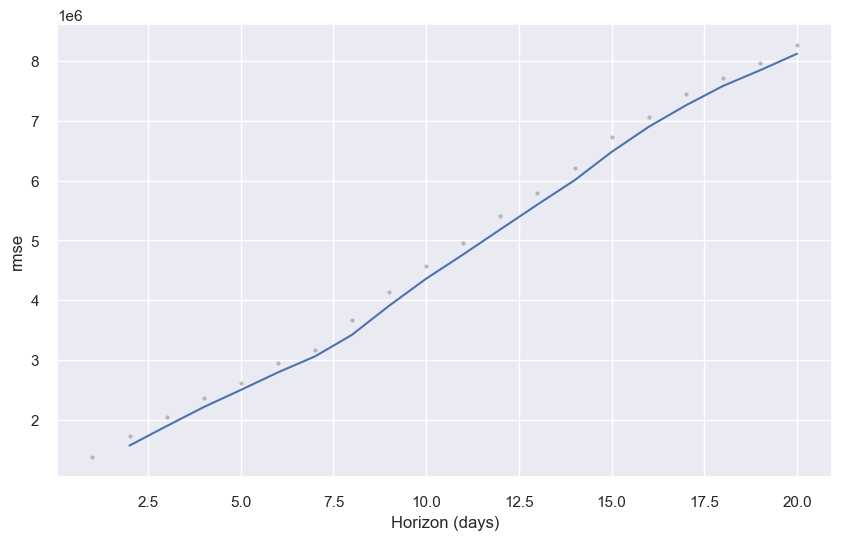

In [339]:
plot_cross_validation_metric(fb_cv,'rmse');

## Parallelizing Cross Validation with Dask

In [340]:
from distributed import Client
from fbprophet.diagnostics import cross_validation

client = Client()
client

<Client: 'tcp://127.0.0.1:55885' processes=4 threads=8, memory=8.00 GiB>

In [341]:

df_cv = cross_validation(model, 
                         horizon="10 days",
                         period="20 days", 
                         initial="60 days", 
                         parallel="dask"
                        )

INFO:fbprophet:Making 1 forecasts with cutoffs between 2021-02-21 00:00:00 and 2021-02-21 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:55885' processes=4 threads=8, memory=8.00 GiB>


In [342]:
from fbprophet.diagnostics import performance_metrics

performance_metrics(df_cv, rolling_window=1)

horizon           mse           rmse            mae      mape     mdape  \
0 10 days  2.681106e+11  517794.012955  361669.319809  0.057789  0.030802   

   coverage  
0       0.4

## Hyperparameter Optimization with Dask

In [343]:
import itertools

param_grid = {'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
              'seasonality_mode': ['additive', 'multiplicative']}

# generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # store the RMSEs for each params here

In [344]:
# go through all parameter combos
for i in range(len(all_params)):
  
    # create & fit model with given params combo
    model = Prophet(daily_seasonality=False, **all_params[i]).fit(train_data)
    
    # cross validate the model 
    df_cv = cross_validation(model, 
                             horizon="60 days",
                             period="182.5 days", 
                             initial="10 days", 
                             parallel="dask")
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    # pull rmse and add it to the list
    rmses.append(df_p['rmse'].values[0])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2021-01-02 00:00:00 and 2021-01-02 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:55885' processes=4 threads=8, memory=8.00 GiB>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2021-01-02 00:00:00 and 2021-01-02 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:55885' processes=4 threads=8, memory=8.00 GiB>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2021-01-02 00:00:00 and 2021-01-02 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:55885' processes=4 threads=8, memory=8.00 GiB>
INFO:fbprophet:Disabling yearly seasonality. Run 

In [345]:
df_p

horizon           mse          rmse           mae      mape     mdape  \
0 60 days  1.721785e+12  1.312168e+06  1.157555e+06  0.255569  0.286919   

   coverage  
0  0.983333

In [84]:
# load cleaned data time series:
df_time_m = pd.read_csv('df_for_model.csv')
#df_time_m = df_time_m[['date','daily_vaccinations', 'country', 'people_fully_vaccinated_per_hundred']]
#df_time_m
# plot the time series
#df_time_m.plot()
#pyplot.show()

In [85]:
#df_time_m.sample(15)

In [86]:
#erste Versuche

In [87]:
df_time_m_us = df_time_m[df_time_m.country == 'United States']
df_time_m_us1 = df_time_m_us[['date','people_vaccinated_per_hundred']]#,'daily_vaccinations', 
#train - test - split

df_time_m_us2 = df_time_m_us1
df_time_m_us2['cap']= 328000000
train_test_split_ratio = int(len(df_time_m_us2)*0.8)
train_data, test_data = df_time_m_us2[:train_test_split_ratio], df_time_m_us2[train_test_split_ratio:]



In [88]:
df_time_m_us2.tail()

date  people_vaccinated_per_hundred        cap
6599  2021-03-19                          23.09  328000000
6600  2021-03-20                          23.73  328000000
6601  2021-03-21                          24.34  328000000
6602  2021-03-22                          24.75  328000000
6603  2021-03-23                          25.10  328000000

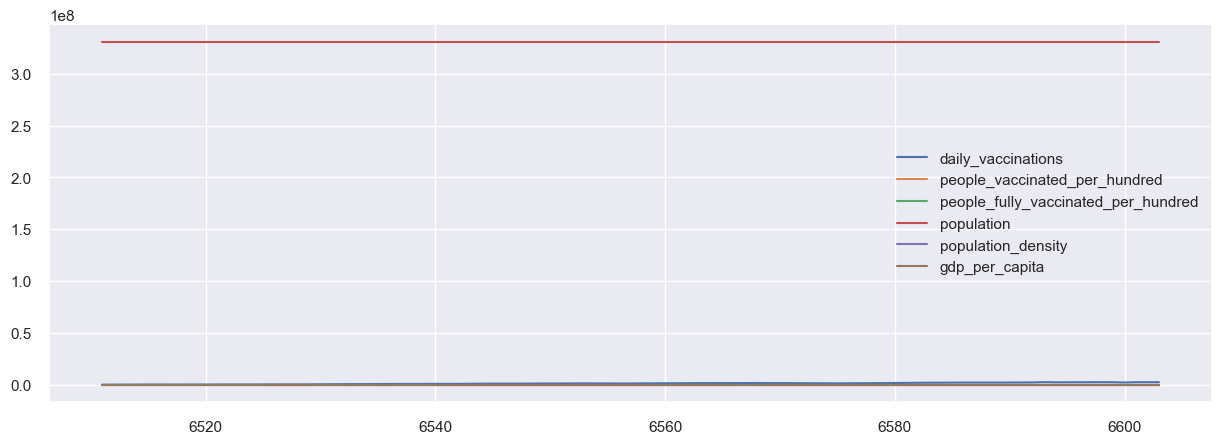

In [89]:
df_time_m_us.plot()
pyplot.show()

In [90]:
# prepare expected column names
train_data.columns = ['ds', 'y', 'cap']
train_data['ds']= pd.to_datetime(train_data['ds'])
# define the model
model = Prophet(growth = 'logistic')
# fit the model
model.fit(train_data)
print(train_data.tail())

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds      y        cap
6580 2021-02-28  14.88  328000000
6581 2021-03-01  15.17  328000000
6582 2021-03-02  15.48  328000000
6583 2021-03-03  15.80  328000000
6584 2021-03-04  16.16  328000000


In [91]:
future = model.make_future_dataframe(periods=71)
future['cap']= 3280000
future.tail()

ds      cap
140 2021-05-10  3280000
141 2021-05-11  3280000
142 2021-05-12  3280000
143 2021-05-13  3280000
144 2021-05-14  3280000

In [92]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
140 2021-05-10  0.579778    0.260079    1.080102
141 2021-05-11  0.630985    0.300459    1.135393
142 2021-05-12  0.530295    0.191822    1.091294
143 2021-05-13  0.598732    0.239546    1.181543
144 2021-05-14  0.646966    0.288632    1.238932

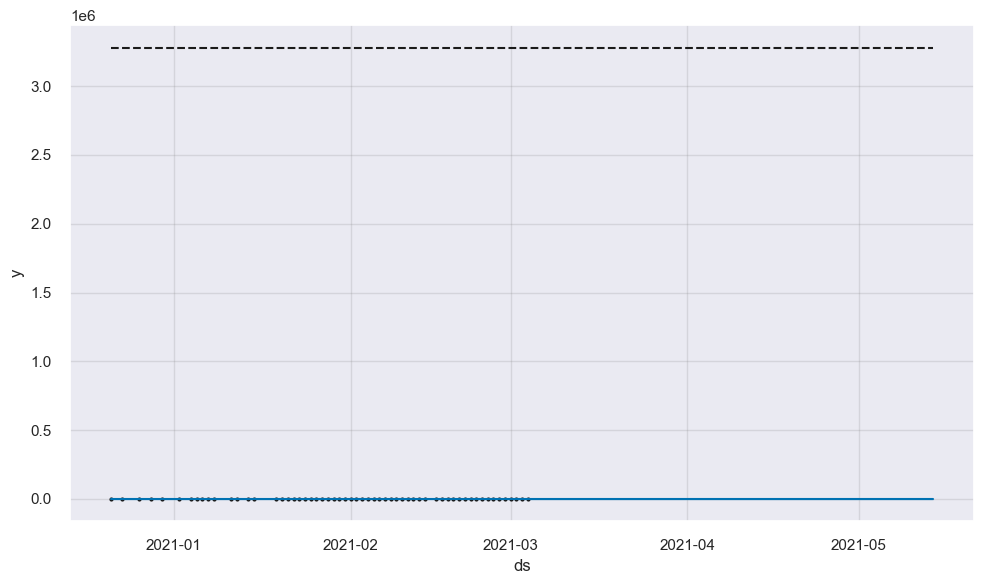

In [93]:
fig1 = model.plot(forecast)

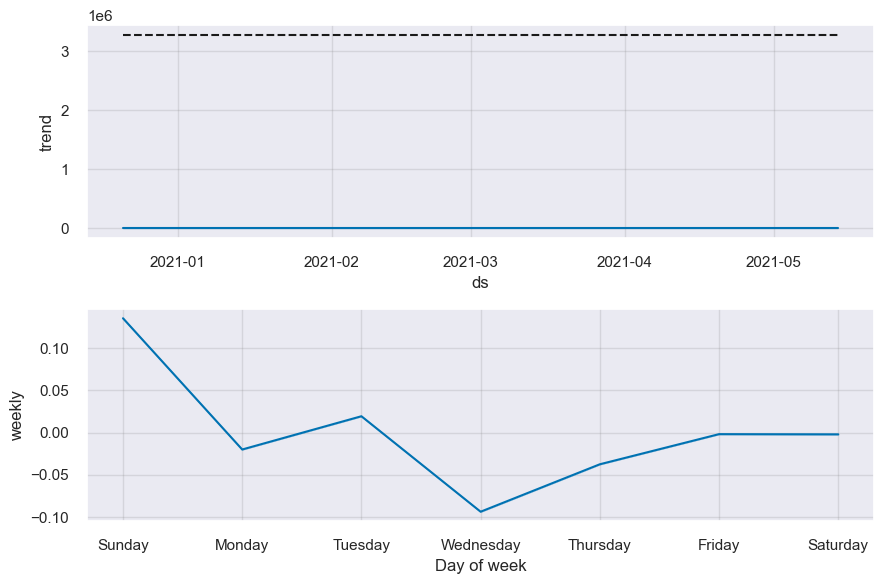

In [94]:
fig2 = model.plot_components(forecast)

In [ ]:
#!install jupyterlab-plotly@4.14.3
#%jupyter labextension install jupyterlab-plotly@4.14.3

In [ ]:
#%jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.14.3

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

## Prediction for Germany

In [346]:
df_time_m_ger = df_time_m[df_time_m.country == 'Germany']
df_time_m_ger1 = df_time_m_ger[['date','daily_vaccinations']]
#train - test - split
df_time_m_ger2 = df_time_m_ger1
train_test_split_ratio = int(len(df_time_m_ger2)*0.8)
train_data, test_data = df_time_m_ger2[:train_test_split_ratio], df_time_m_ger2[train_test_split_ratio:]



In [347]:
# prepare expected column names
train_data.columns = ['ds', 'y']
train_data['ds']= pd.to_datetime(train_data['ds'])
# define the model
model = Prophet()
# fit the model
model.fit(train_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [348]:
future = model.make_future_dataframe(periods=365)
future['cap']= 80000000
future.tail()

ds       cap
428 2022-03-01  80000000
429 2022-03-02  80000000
430 2022-03-03  80000000
431 2022-03-04  80000000
432 2022-03-05  80000000

In [349]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
428 2022-03-01  1.623271e+06  1.015769e+06  2.246334e+06
429 2022-03-02  1.628458e+06  1.015266e+06  2.254264e+06
430 2022-03-03  1.632966e+06  1.014755e+06  2.261490e+06
431 2022-03-04  1.637568e+06  1.019658e+06  2.272307e+06
432 2022-03-05  1.639399e+06  1.021268e+06  2.275471e+06

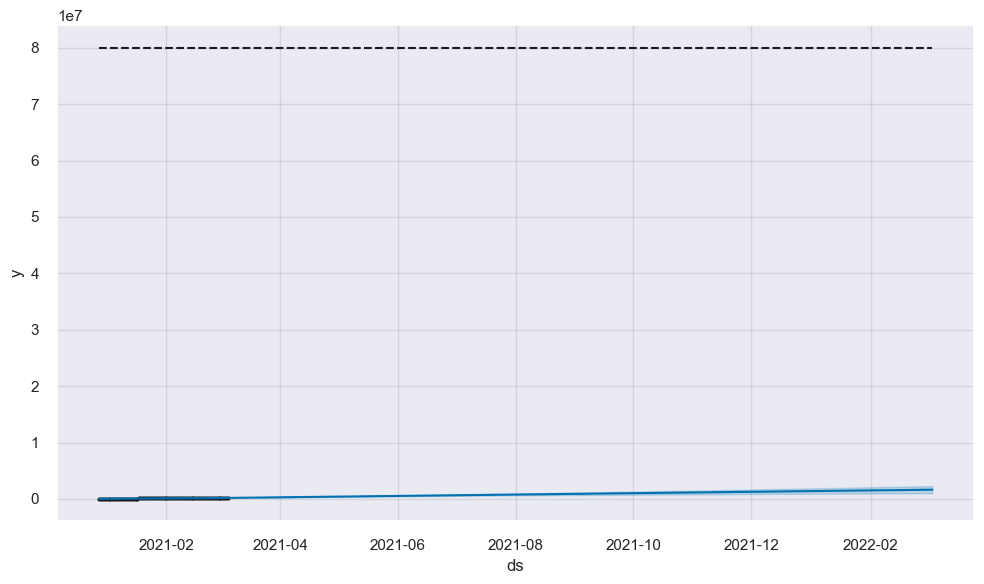

In [350]:
fig1 = model.plot(forecast)

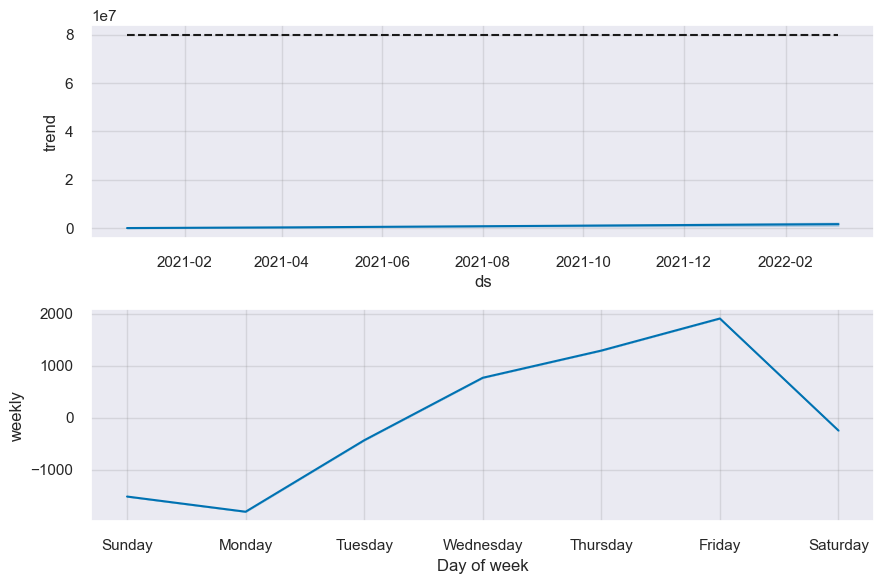

In [351]:
fig2 = model.plot_components(forecast)

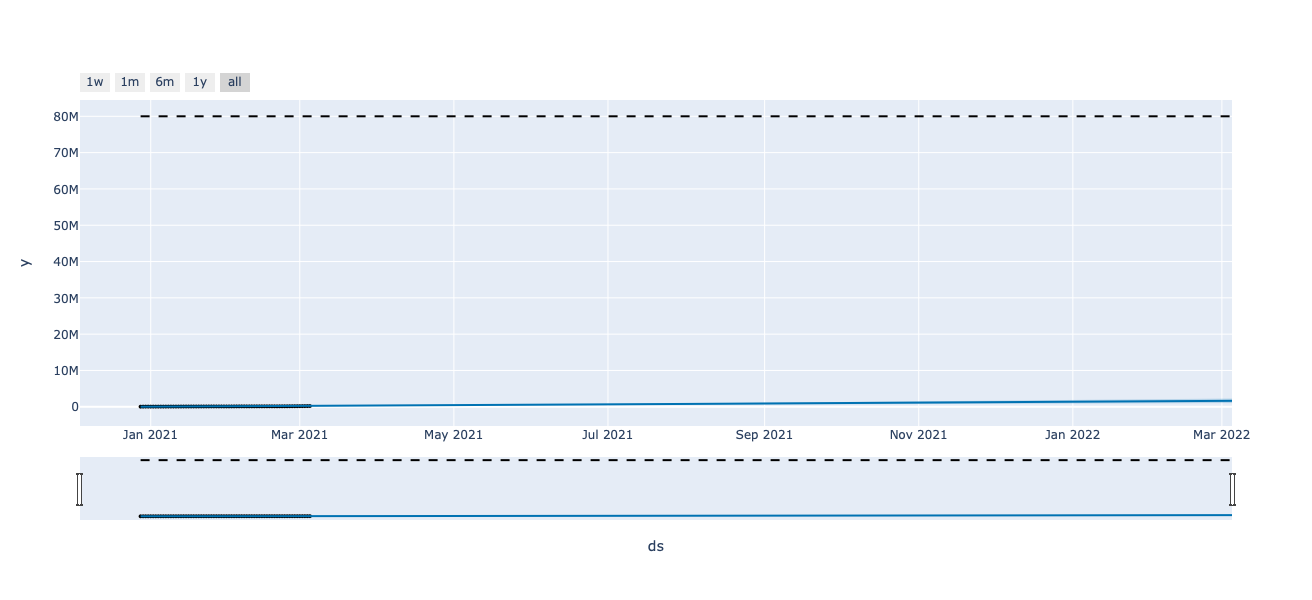

In [352]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [353]:
#for other countries:

In [354]:
top_10_vacc = list(df_time_m[(~df_time_m['people_fully_vaccinated_per_hundred'].isna())&(df_time_m['date']=='2021-03-28')].sort_values(by='people_fully_vaccinated_per_hundred',ascending=False).head(10)['country'])

In [355]:
top_10_vacc

[]

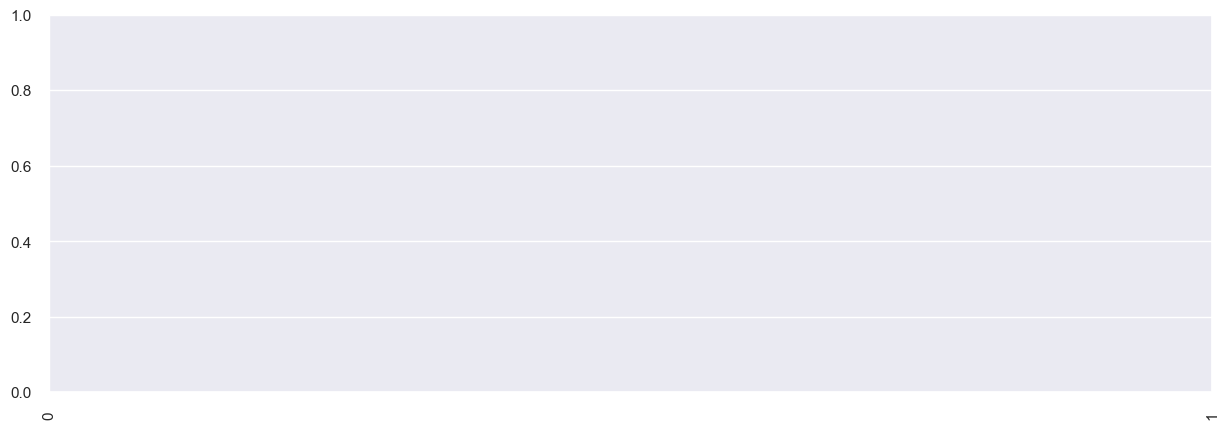

In [356]:
#Top 10 GDP countries in the world vaccination rates
graph = sns.lineplot(data=df_time_m[df_time_m['country'].isin(top_10_vacc)]
                     .sort_values(by="date"), x="date", y="people_fully_vaccinated_per_hundred",hue='country')
graph.xaxis.set_major_locator(mdates.DayLocator(interval = 7))
# graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)

plt.show()

In [357]:
def fcast(cntry):
    p = df_time_m[df_time_m['country'].isin([cntry])].sort_values(by="date")[['date',"people_fully_vaccinated_per_hundred"]]
    p.columns = ['ds', 'y']
    # define the model
    model = Prophet()
    # # fit the model
    model.fit(p)
    # define the period for which we want a prediction
    future = list()
    for i in range(1, 13):
        date = '2021-%02d' % i
        future.append([date])
    for i in range(1, 13):
        date = '2022-%02d' % i
        future.append([date])    
    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['ds']= pd.to_datetime(future['ds'])
    
    # use the model to make a forecast
    forecast = model.predict(future)
    # summarize the forecast
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10))
    # plot forecast
    model.plot(forecast)
    plt.ylim(0, 100)
    n_lower=forecast['yhat_lower'].sub(100).abs().idxmin()
    n_upper=forecast['yhat_upper'].sub(100).abs().idxmin()
    plt.title(cntry 
              + ' forecast of people_fully_vaccinated_per_hundred: 100% expected between ' 
              + forecast[n_upper:n_upper+1]['ds'].iloc[0].strftime('%Y-%m-%d') 
              + ' and ' 
              + forecast[n_lower:n_lower+1]['ds'].iloc[0].strftime('%Y-%m-%d'))
    plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds        yhat  yhat_lower  yhat_upper
0 2021-01-01    0.079691   -0.199144    0.372171
1 2021-02-01   21.664094   21.379948   21.972990
2 2021-03-01   40.124951   39.843693   40.412478
3 2021-04-01   60.517517   59.274041   61.790268
4 2021-05-01   79.284050   66.495525   91.948587
5 2021-06-01   99.408272   67.883646  130.010907
6 2021-07-01  119.072627   65.049857  173.880591
7 2021-08-01  138.549725   60.483504  215.911579
8 2021-09-01  158.792849   51.747925  265.306765
9 2021-10-01  178.061082   38.486601  313.943548


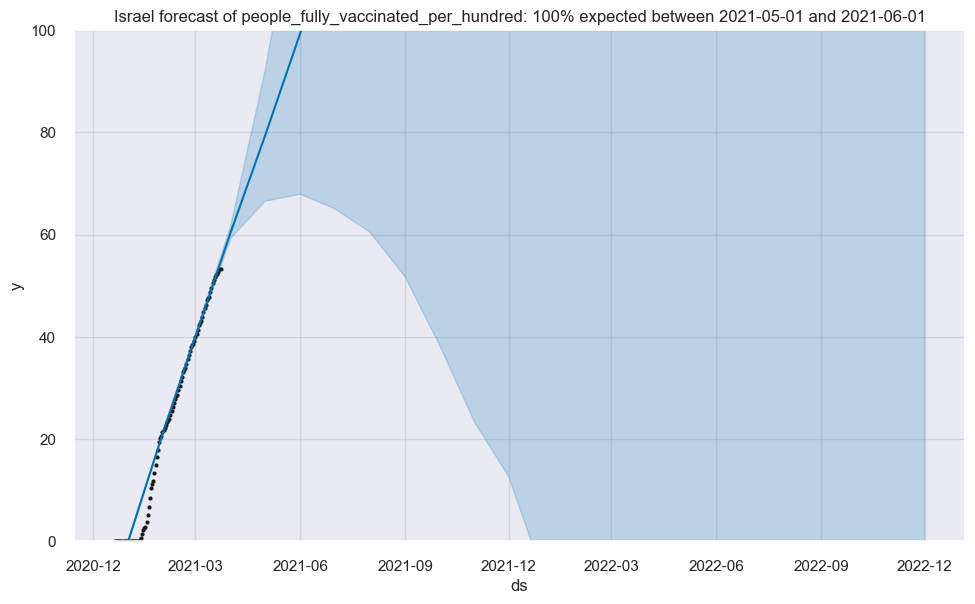

In [358]:
fcast('Israel')

In [ ]:
fcast('United States')

In [ ]:
fcast('Germany')

In [ ]:
fcast('India')

In [ ]:
df_time_m_us = df_time_m[df_time_m.country == 'United States']
df_time_m_us1 = df_time_m_us[['date','daily_vaccinations']]
#train - test - split
df_time_m_us2 = df_time_m_us1
train_test_split_ratio = int(len(df_time_m_us2)*0.8)
train_data, test_data = df_time_m_us2[:train_test_split_ratio], df_time_m_us2[train_test_split_ratio:]



In [ ]:
# prepare expected column names
train_data.columns = ['ds', 'y']
train_data['ds']= pd.to_datetime(train_data['ds'])
# define the model
model = Prophet()
# fit the model
model.fit(train_data)

Make an In-Sample Forecast

forecast on historical data.

That is, we can make a forecast on data used as input to train the model. Ideally, the model has seen the data before and would make a perfect prediction.

Nevertheless, this is not the case as the model tries to generalize across all cases in the data.

This is called making an in-sample (in training set sample) forecast and reviewing the results can give insight into how good the model is. That is, how well it learned the training data.

A forecast is made by calling the predict() function and passing a DataFrame that contains one column named ‘ds‘ and rows with date-times for all the intervals to be predicted.

There are many ways to create this “forecast” DataFrame. In this case, we will loop over the month december 2020 to end of February 2021.

In [ ]:
# define the period for which we want a prediction
future = list()
for i in range(1, 29):
    date = '2021-02-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

The training data are represented as black dots and the forecast is a blue line with upper and lower bounds in a blue shaded area.

We can see that the forecasted days are not a good match for the real observations. It is better when the bounds are taken into account but the last decrease in daily vaccinations was not met.

## Make an Out-of-Sample Forecast

 model to make a prediction beyond the training data.


In [ ]:
future = list()
for i in range(1, 30):
    date = '2021-03-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(50))
# plot forecast
model.plot(forecast)
pyplot.show()

Manually Evaluate Forecast Model

In [ ]:
df_time_m_us2 = df_time_m_us1
train_test_split_ratio = int(len(df_time_m_us2)*0.8)
train_data, test_data = df_time_m_us2[:train_test_split_ratio], df_time_m_us2[train_test_split_ratio:]
# prepare expected column names
train_data.columns = ['ds', 'y']
train_data['ds']= pd.to_datetime(train_data['ds'])
test_data.columns = ['ds', 'y']
test_data['ds']= pd.to_datetime(test_data['ds'])

In [ ]:
test_data['y'] = test_data['y'].astype(int)
train_data['y'] = train_data['y'].astype(int)

In [ ]:
future = list()
for i in range(1, 30):
    date = '2021-03-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(50))
# plot forecast
model.plot(forecast)
pyplot.show()

In [ ]:
# create test dataset, remove last months
train = train_data.drop(train_data.index[-12:])
print(train.tail())
print(train_data.head())

In [ ]:
# calculate MAE between expected and predicted values for december
y_true = test_data['y'].values[-29:]#y_true = train_data['y'].values#[-1:]
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

In [ ]:
y_true.shape

In [ ]:
y_pred.shape

In [ ]:
# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
test_timestamps = []
for i in range (10):
    test_timestamps.append(pd.to_datetime(df_time_m.index[-1]) - (i+1)*pd.Timedelta(hours=24))
test_timestamps.sort()

val_timestamps = [pd.to_datetime("2020-12-13")]
for i in range (9):
    val_timestamps.append(pd.to_datetime(val_timestamps[0]) + (i+1)*pd.Timedelta(hours=24))
val_timestamps.sort()

Error Metrics Function (RMSE, R2, MAE, MAPE)

In [ ]:
def error_metrics(y_pred, y_truth, model_name = "default"):
    """
    Calculate error metrics for a single comparison between predicted and observed values
    """
    # calculating error metrics
    RMSE_return = np.sqrt(mean_squared_error(y_truth, y_pred))
    R2_return = r2_score(y_truth, y_pred)
    MAE_return = mean_absolute_error(y_truth, y_pred)
    MAPE_return = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)
    
    # saving error metrics in a dataframe and returning it
    name_error = ['RMSE', 'R2', 'MAE', 'MAPE']
    value_error = [RMSE_return, R2_return, MAE_return, MAPE_return/100]
    dict_error = dict()
    for i in range(len(name_error)):
        dict_error[name_error[i]] = [value_error[i]]
    errors = pd.DataFrame(dict_error).T
    errors.rename(columns={0 : model_name}, inplace = True)
    
    path = './data/error_metrics_{}.pkl'.format(model_name)
    errors.to_pickle(path)
        
    return(errors)

FB Prophet Prediction (hier auch noch mehr zu FB Prophet schreiben)

In [ ]:
def stan_init(m):
    """Retrieve parameters from a trained model.
    
    Retrieve parameters from a trained model in the format
    used to initialize a new Stan model.
    
    Parameters
    ----------
    m: A trained model of the Prophet class.
    
    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0]
    return res

In [ ]:
def rolling_prophet_model(data, tfstart, prediction_window_size_hrs = 24, train_window_size_days = 90,
                          timesteps = 18, lags = 1, logtransformation = True, target_name = "target_losses_norm"):
    """
        Predict values with a Prophet Model for a chosen timespan with a rolling-forward training window of a
        chosen size (differenced time series will be predicted).
        - data: input dataframe
        - tfstart: start timestamp of the timespan to predict for
        - prediction_window_size_hrs: size of the prediction window in hours
        - train_window_size_days: size of the training window in days
        - timesteps: number of timesteps that will be predicted ahead on each step 
        - lags: number of lags of the target_variable that should be included in the dataframe
        - logtransformation: should the target variable be transformed with the log-function for the prediction
        - target_name: column name of the target variable
        
    """
    #creating a working data frame to not change the actual input dataframe
    workframe = data.copy(deep = True)
    
    #if logtransformation is wanted
    if logtransformation == True:
        workframe[target_name] = np.log(workframe[target_name])
    
    #if lags should be included, they will be generated
    for i in range(lags):
        workframe[f"lag{i+1}"] = workframe[target_name].shift(i+1)
        
    #nan values after creation of lags will be dropped
    workframe.dropna(inplace = True)

    #creating another copy to keep the undifferenced values for backtransformation
    workframe_real = workframe.copy(deep = True)
    
    #calculating the differenced values for the target column
    workframe[target_name] = workframe[target_name].diff(1)
    
    #calculating the differenced values for the included lags
    if lags >= 1:
        for i in range(lags):
            workframe[f"lag{i+1}"] = workframe[f"lag{i+1}"].diff(1)
            
    #nan values after creation of lags will be dropped
    workframe.dropna(inplace = True)
        
    #setting start point of initial training window dependent on training window size
    train_start = pd.to_datetime(tfstart) - pd.Timedelta(days = train_window_size_days)
    
    #setting end point of test set dependent on chosen prediction window size
    tfend = pd.to_datetime(tfstart) + pd.Timedelta(hours = prediction_window_size_hrs)
    
    #making working dataframe compatible with fbprophet
    workframe.rename(columns={target_name: "y"}, inplace = True)
    
    #splitting data in train and test
    df_test = workframe[(workframe.index >= tfstart) & (workframe.index <= tfend)]    
    df_train = workframe[(workframe.index >= train_start) & (workframe.index < tfstart)]
    
    #making the copy with the undifferenced target values compatible with prophet
    workframe_real.rename(columns={target_name: "y"}, inplace = True)
    
    #creating copy of the undifferenced test data for later evalutation against predictions    
    y_test = list()
    for i in range(timesteps):
        y_test.append(workframe_real[(workframe_real.index > tfstart) & (workframe_real.index < tfend)]["y"].shift(-i).iloc[:-timesteps])
  
    #saving all the additional regressors (not the target) in list
    regressors = list(df_train.columns)
    regressors.remove("y")
    
    #adding datestamps to dataframes for compatibility with fbprophet
    df_test["ds"] = df_test.index
    df_train["ds"] = df_train.index
    
    # setting up a list to store the prediction results in
    predictions = list()

    #iterating over the test set
    for t in tqdm(range(len(df_test)-timesteps)):
            
            #initializing new Prophet model
            model = Prophet(yearly_seasonality = False)
            
            #adding all the regressors with the same hyperparameters
            for name in list(regressors):
                model.add_regressor(name, prior_scale = 1, standardize = True, mode='multiplicative')            
            
            #training the model on the current training dataframe with the saved initial parameters from the last model, if there was one
            try:
                model.fit(df_train, init = parameters);
            except NameError:
                model.fit(df_train);
            
            #saving the parameters of the fitted model for warm-start training of the next model
            parameters = stan_init(model)
            
            #the timestamp before the current prediciton timestep is calculated
            index_before = df_test.index[0] - pd.Timedelta(minutes = 10)

            #setting up future dataframe (two steps ahead) with all regressors filled in assumption of perfect forecast for regressors
            future = df_test.drop(columns = ["y"]).iloc[0:timesteps] #.to_frame().T
            
            #predicting next timestep
            forecast = model.predict(future)
            
            predictions_inner_list = list()
            
            # setting the physically possible boundaries of the predictions (must be between 0 and 1 after backtransformation) depending on the chosen transformations
            for i in range(timesteps):
                if (logtransformation == True):
                    if forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"] < -30:
                         predictions_inner_list.append(-30)
                    elif forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"] >= 0:
                         predictions_inner_list.append(0)
                    else:
                         predictions_inner_list.append(forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"])
                            
                else:
                    if forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"] < 0:
                        predictions_inner_list.append(0)
                    elif forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"] >= 1:
                        predictions_inner_list.append(1)
                    else:
                        predictions_inner_list.append(forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"])
                    
            predictions.append(predictions_inner_list)
                                         
            #dropping the left end point of the training dataframe            
            df_train.drop(df_train.index[0], inplace = True)
            
            #appending the left end point of the test dataframe to the training dataframe
            df_train = df_train.append(df_test.iloc[0].to_frame().T)
            
            #dropping the left end point of the test dataframe
            df_test.drop(df_test.index[0], inplace = True)
            
    columnnames = list()
    testcolumnnames = list()
    
    for i in range(timesteps):
        columnnames.append(f"y_pred{i+1}")
        testcolumnnames.append(f"y_test{i+1}")

    results = pd.DataFrame(columns = columnnames)
    original = pd.DataFrame(columns = testcolumnnames)
    
    for i in range(timesteps):
        results[f"y_pred{i+1}"] = pd.Series(v for v in [el[i] for el in predictions])
        original[f"y_test{i+1}"] = y_test[i]
        

    #setting the indices as they were 
    results.index = y_test[0].index
    
    #backtransformation to real values if logtransformation was used
    if logtransformation == True:
        results = np.exp(results)
        original = np.exp(original)
         
    ##creating the dataframe that will be saved as a file
    #results.to_csv(f".data/{filename}_predictions.csv")
    #original.to_csv(f".data/{filename}_test.csv")
    #print(f"Predictions and test values saved.")
    
    #returning the dataframes with the results
    return results, original

Tuning Prophet Model on Validation Data

In [ ]:
y_pred, y_test = rolling_prophet_model(data = df_time_m, tfstart = val_timestamps[0], prediction_window_size_hrs = 240, train_window_size_days = 60, timesteps = 18, lags = 2, logtransformation = True, target_name = "people_fully_vaccinated_per_hundred")

In [ ]:
columnnames = list()
for i in range(18):
    columnnames.append(f"FB Prophet Prediction Step {i+1}")
    
val_errors = pd.DataFrame(columns = columnnames)

for i in range(18):
    val_errors[f"FB Prophet Prediction Step {i+1}"]  = error_metrics(y_pred[f"y_pred{i+1}"],y_test[f"y_test{i+1}"])["default"]
    
val_errors = val_errors.T

## Parallelizing Cross Validation with Dask

In [241]:
from distributed import Client
from fbprophet.diagnostics import cross_validation

client = Client()
client

<Client: 'tcp://127.0.0.1:55447' processes=4 threads=8, memory=8.00 GiB>

In [242]:
%%time
df_cv = cross_validation(model, 
                         horizon="365 days",
                         period="182.5 days", 
                         initial="730 days", 
                         parallel="dask"
                        )

ValueError: Less data than horizon.